In [37]:
# Enable autoreload of local Python modules (e.g., models)
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import numpy as np
import jax
import jax.numpy as jnp
import optax
import time

# local imports
from models.lstm import LSTM
import util.generation as generation


In [39]:
# initialize the jax random key
key = jax.random.key(0)

# Load data

In [40]:
# load the ./data/text8_train.txt and ./data/text8_test.txt files
with open("./data/text8_train.txt", "r") as f:
    train_text = f.read()
with open("./data/text8_test.txt", "r") as f:
    test_text = f.read()

# print the length of the training text and test text
print(f"Length of training text: {len(train_text):_} characters")
print(f"Length of test text: {len(test_text):_} characters")

Length of training text: 90_000_000 characters
Length of test text: 5_000_000 characters


In [41]:
# Build vocabulary (lowercase + space + a few punctuations)
char_set = list("abcdefghijklmnopqrstuvwxyz ")
char_to_int = {ch:i for i,ch in enumerate(char_set)}
int_to_char = {i:ch for ch,i in char_to_int.items()}

def encode(s):
    """Encode string to array of integers"""
    ids = [char_to_int[c] for c in s]
    return np.array(ids, dtype=np.uint8)  # use np.uint8 to save space

In [42]:
# encode the text
train_text_int = encode(train_text)
test_text_int = encode(test_text)

In [43]:
# sanity check: display a few random characters from the training text
T = 128
for _ in range(5):
    # choose random position in text
    N = np.random.randint(low=0, high=len(train_text)-T)
    print(train_text[N:N+T])
    print()

ctually entered epirus demanded in a somewhat threatening manner that if he were thus suddenly bidden to desist from war he shou

ted hd broadcasting in january two zero zero one but only in august two zero zero three was hd content mandated most cities in a

orm nurseries would eradicate the disease pasteur also discovered anaerobiosis whereby some microorganisms can develop and live 

sity less and less suitable for use in gasoline they form instead the major part of diesel and aviation fuel diesel fuels are ch

tar wars films industrial light and magic steven spielberg jaws the one nine nine zero s technical advances the history of film 



# Create a basic LSTM model

In [44]:
def create_train_state(rng, vocab_size=27, hidden_size=64, n_layers=6, max_len=128):
    # create a basic LSTM model
    model = LSTM(vocab_size, hidden_size, n_layers, max_len)
    # create a dummy input for initialization
    dummy = jnp.zeros((1, min(16, max_len)), dtype=jnp.int32)
    # pass the dummy input to the model to initialize the parameters
    params = model.init({"params": rng}, dummy)["params"]
    return model, params

In [45]:
# vocab size
vocab_size= len(char_set)

# internal model dimensions
d_model=128

# number of LSTM layers
n_layers=3

# maximum sequence length
max_len=128

model, params = create_train_state(key, vocab_size, d_model, n_layers, max_len)

AttributeError: "Embed" object has no attribute "embedding". If "embedding" is defined in '.setup()', remember these fields are only accessible from inside 'init' or 'apply'.

In [ ]:
# compute the number of parameters
def count_params(params):
    return sum(x.size for x in jax.tree_util.tree_leaves(params))
print(f"Number of parameters: {count_params(params):_}")

Number of parameters: 418_075


In [ ]:
# sanity check: create a batch of data & run a forward pass
B, T = 4, 32
batch = jax.random.randint(
    key=key,
    shape=(B, T), minval=0, maxval=len(char_set))
logits, states = model.apply({"params": params}, batch)

print("batch shape:", batch.shape)  # (B, T)
print("logits shape:", logits.shape)  # (B, T, vocab_size)

batch shape: (4, 32)
logits shape: (4, 32, 27)


In [ ]:
len(states)

3

In [ ]:
type(logits)

jaxlib._jax.ArrayImpl

# Loss function

In [ ]:
@jax.jit
def loss_and_metrics(logits, targets):
    """Compute cross-entropy loss and accuracy.

    Assumes `targets` contains only valid integer class ids in [0, V-1] (no -1 ignore tokens).

    Args:
      logits: (B, T, V) float array of unnormalized scores.
      targets: (B, T) integer array with ground-truth class ids.

    Returns:
      loss: scalar average cross-entropy over all positions.
      metrics: dict with keys "loss" and "acc" (both scalars).
    """
    # Flatten batch/time dims so optax works on shape (N, V) and (N,)
    vocab = logits.shape[-1]
    flat_logits = logits.reshape(-1, vocab)
    flat_targets = targets.reshape(-1)

    # Per-position cross-entropy, then mean over all positions
    per_pos = optax.softmax_cross_entropy_with_integer_labels(flat_logits, flat_targets)
    loss = per_pos.mean()

    # prediction over all positions
    preds = jnp.argmax(logits, axis=-1)  # (B, T)
    
    # compute accuracy over only the last position
    is_match = preds == targets
    
    # Accuracy over all positions
    acc_all = jnp.mean(is_match.astype(jnp.float32))
    
    # Accuracy over only last position
    acc_last = jnp.mean(is_match.astype(jnp.float32)[:,-1])

    return loss, {"loss": loss, "acc": acc_all, "acc_last": acc_last}

# Optimization step:

In [ ]:
# create an update function
def train_step(params, opt_state, x, y, tx):
    """Single optimization step using optax optimizer.

    Args:
      params: pytree of model parameters.
      opt_state: optax optimizer state corresponding to `params`.
      x: (B, T) int array input tokens.
      y: (B, T) int array target tokens.
      tx: optax.GradientTransformation (already initialized).

    Returns:
      new_params: updated parameters after one gradient step.
      new_opt_state: updated optimizer state.
      metrics: dict of scalar metrics (loss, acc).
    """
    def loss_fn(params):
        logits, states = model.apply({"params": params}, x)
        loss, metrics = loss_and_metrics(logits, y)
        return loss, metrics

    # compute gradients (loss is scalar, metrics is auxiliary)
    (loss, metrics), grads = jax.value_and_grad(loss_fn, has_aux=True)(params)

    # optax update: compute parameter updates and new optimizer state
    updates, new_opt_state = tx.update(grads, opt_state, params)
    new_params = optax.apply_updates(params, updates)
    return new_params, new_opt_state, metrics

# jit: last argument should be static because it is an object
train_step = jax.jit(train_step, static_argnames=("tx",))

# Batch creation:

In [ ]:
# create a batch from the training data
def get_batch(text_int, B, T):
    """Create a random batch of data from text_int.

    Args:
      text_int: 1D array of token ids.
      B: batch size (number of sequences).
      T: sequence length (number of tokens per sequence).

    Returns:
      x: (B, T) int array input tokens.
      y: (B, T) int array target tokens.
    """
    # choose random starting indices for each sequence in the batch
    ix = np.random.randint(0, len(text_int) - T, size=B)
    # inputs are text from i to i+T
    x = np.stack([text_int[i:i+T] for i in ix])
    # targets are text from i+1 to i+T+1
    y = np.stack([text_int[i+1:i+T+1] for i in ix])
    return jnp.array(x, dtype=jnp.int32), jnp.array(y, dtype=jnp.int32)

# Optimizer creation:

In [ ]:
# define optax optimizer
learning_rate = 0.001
# Create Adam optimizer (Optax)
tx = optax.adam(learning_rate=learning_rate)
# Initialize optimizer state for current params
opt_state = tx.init(params)
print(f"Initialized optimizer: Adam lr={learning_rate}")



Initialized optimizer: Adam lr=0.001


In [ ]:
niter = 1_000
B, T = 128, 32
loss_history = []
time_history = []
time_test_history = []
loss_test_history = []
time_start = time.time()
for it in range(niter):
    batch = get_batch(train_text_int, B, T)
    input, target = batch[0], batch[1]
    params_new, opt_state_new, metrics = train_step(params, opt_state, input, target, tx)

    # update params and opt_state
    params = params_new
    opt_state = opt_state_new
    acc = metrics['acc']
    acc_last = metrics['acc_last']
    loss = metrics['loss']
    
    loss_history.append(loss)
    time_history.append(time.time() - time_start)
    
    if it % (niter // 50) == 0 or it == niter - 1:
        time_since_start = time.time() - time_start
        # compute loss on test set
        B_test, T_test = 1024, 32
        test_batch = get_batch(test_text_int, B_test, T_test)
        test_input, test_target = test_batch[0], test_batch[1]
        test_logits, _ = model.apply({"params": params}, test_input)
        test_loss, test_metrics = loss_and_metrics(test_logits, test_target)
        test_acc = test_metrics['acc']
        test_acc_last = test_metrics['acc_last']
        loss_test_history.append(test_loss)
        time_test_history.append(time_since_start)
        if it % (niter // 5) == 0 or it == niter - 1:
            print(f"iteration {it:_}  time: {time_since_start:.1f} seconds")
            print(f"\t \t loss(train :: test): {loss:.4f} :: {test_loss:.4f}")
            print(f"\t \t accuracy (train :: test): {100*acc:.1f}% :: {100*test_acc:.1f}%")
            print(f"\t \t accuracy (last character) (train :: test): {100*acc_last:.1f}% :: {100*test_acc_last:.1f}%")
            print()


iteration 0  time: 0.0 seconds
	 	 loss(train :: test): 2.1392 :: 2.1411
	 	 accuracy (train :: test): 36.1% :: 36.7%
	 	 accuracy (last character) (train :: test): 43.8% :: 38.3%

iteration 200  time: 82.3 seconds
	 	 loss(train :: test): 2.0511 :: 1.9834
	 	 accuracy (train :: test): 38.4% :: 40.9%
	 	 accuracy (last character) (train :: test): 37.5% :: 41.2%

iteration 400  time: 169.5 seconds
	 	 loss(train :: test): 1.9439 :: 1.8761
	 	 accuracy (train :: test): 41.6% :: 43.3%
	 	 accuracy (last character) (train :: test): 32.8% :: 47.1%

iteration 600  time: 259.9 seconds
	 	 loss(train :: test): 1.8067 :: 1.8186
	 	 accuracy (train :: test): 46.3% :: 45.1%
	 	 accuracy (last character) (train :: test): 45.3% :: 47.6%

iteration 800  time: 348.8 seconds
	 	 loss(train :: test): 1.7673 :: 1.7772
	 	 accuracy (train :: test): 46.5% :: 46.8%
	 	 accuracy (last character) (train :: test): 46.9% :: 48.1%

iteration 999  time: 435.9 seconds
	 	 loss(train :: test): 1.7140 :: 1.7024
	 	

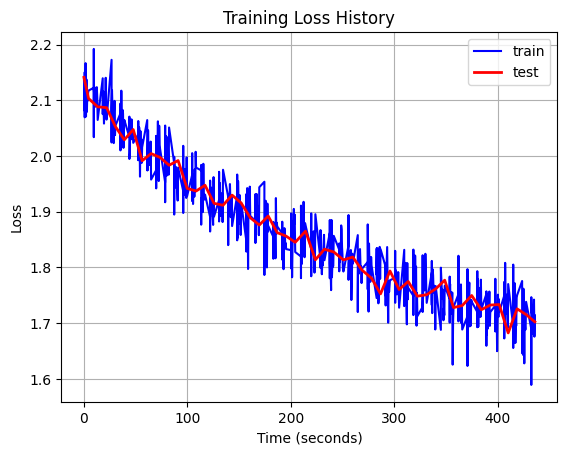

In [ ]:
# plot the loss history
import matplotlib.pyplot as plt
plt.plot(time_history, loss_history, '-', label='train', color="blue")
plt.plot(time_test_history, loss_test_history, '-', label='test', lw=2, color="red")
plt.xlabel("Time (seconds)")
plt.ylabel("Loss")
plt.legend(loc='upper right')
plt.title("Training Loss History")
plt.grid()

In [ ]:
B = 1
seed = 42
rng = jax.random.PRNGKey(seed)
prompt = "hello my fri"
# prompt_int = encode(prompt.lower())
prompt_int = jnp.array([ [char_to_int.get(c, len(char_set)) for c in prompt.lower()[:64]] ], dtype=jnp.int32)

gen_len = 1000
out_ids = generation.generate_tokens(model, params, rng, prompt_int, gen_len, block_size=64, 
                          temperature=0.7, sample=True)
print('generated ids shape:', out_ids.shape)
print('generated text:')
generated_text = ''.join(int_to_char.get(int(x), '?') for x in list(out_ids[0]))
# concatenate with prompt
print(prompt + generated_text)
#print(''.join(int_to_char.get(int(x), '?') for x in list(out_ids[0])))

AttributeError: "Embed" object has no attribute "embedding". If "embedding" is defined in '.setup()', remember these fields are only accessible from inside 'init' or 'apply'.